# Problem Context

**Background and Context**

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

# Problem Statement

**Objective**

To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

# Questions to be answered

How many different segments of customers are there?

How are these segments different from each other?

What are your recommendations to the bank on how to better market to and service these customers?

# Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**

Sl_No: Primary key of the records

Customer Key: Customer identification number

Average Credit Limit: Average credit limit of each customer for all credit cards

Total credit cards: Total number of credit cards possessed by the customer

Total visits bank: Total number of visits that customer made (yearly) personally to the bank

Total visits online: Total number of visits or online logins made by the customer (yearly)

Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

Assumptions

All the customers have access to the internet/online banking services.

# Importing the libraries required

In [1]:
##Connect to Google drive to read and write to files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

#Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Command to tell python to actually display the graphs
%matplotlib inline

# Supress warnings
import warnings
warnings.filterwarnings('ignore') 

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet



# Data Exploration

# Loading the dataset

In [3]:
data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/CreditCardCustomerData.xlsx")

#Overview of the dataset

**Understand the shape of the dataset**


In [4]:
print("The dataset has {} rows and {} columns".format(data.shape[0], data.shape[1]))

The dataset has 660 rows and 7 columns


**View the first and last 5 rows of the dataset**


In [5]:
data.head(5)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [6]:
data.tail(5)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


**Observation** - Avg_Credit_Limit column has higher magnitude compared to other columns and so it will dominate any measure of distance. We will have to scale the data.

**Check the data types of the columns**

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


All the 7 columns are numeric. 

No data seems missing. 

Need to look into the Sl_No and Customer Key columns to see if they are index columns with all unique values.

The memory usage is at 36.2KB.

**Let us confirm there are no missing values.**

In [8]:
data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

# Feature Engineering

**Selection of Features**

In [9]:
#Check to see if Sl_No & Customer Key columns are merely index columns with unique values
data['Sl_No'].nunique()

660

**Sl_No containx unique values and will not add any predictive power to the machine learning model and can hence be dropped.**

In [10]:
data['Customer Key'].nunique()

655

We only have 655 unique values in the Customer Key column. Let us take a closer look at the 5 entries that are not unique.

In [11]:
# Retrieve the rows with the same value in the Customer Key column.
temp = data[data['Customer Key'].duplicated(keep=False) == True]
temp.sort_values('Customer Key')

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


Except for the value in the Customer Key column, the rest of the columns do not contain duplicate data. Perhaps the duplicate rows contain updated information of the same customer. It is safe to ignore the Customer Key entry for training purposes.

Also, looking at the Sl_No values, looks like 4 out of 5 duplicate rows (Customer Key values: 37252, 50706, 96929, 97935) were created when the customer's avg credit limit went up along with the number of cards. As the credit limit went up, the online visits seem to have gone up. There is one scenario (Customer Key = 47437) where the credit limit has dropped significantly from 100000 to 17000. In this case, the online visits have dropped from 12 to 1 and the visits have gone up from 0 to 3.

In [12]:
data.drop('Customer Key', axis=1, inplace=True)

In [13]:
data.drop('Sl_No', axis=1, inplace=True)



In [14]:
#Confirm that we are now left with 5 columns
data.shape[1]

5

**Duplicates - Now that we have dropped the 2 columns with all unique values, lets check the dataset for duplicate rows**

In [15]:
print('Found {} duplicate rows'.format(data.duplicated().sum()))

Found 11 duplicate rows


In [16]:
# Select duplicate rows based on all columns
temp = data[data.duplicated(keep=False)]
temp

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
17,8000,2,0,3,4
29,8000,4,0,4,7
56,6000,1,0,2,5
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
250,18000,6,3,1,4
252,9000,4,5,0,4
257,10000,6,4,2,3
295,10000,6,4,2,3


The values look legit and lets not delete any of the rows.

# Statistical summary of the data

In [17]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


"Avg_Credit_Limit" ranges from 3K to 200K with an avg of 34.5K but 50% of customers have a credit limit <= 18K. The data is heavily right skewed indicating existance of outliers in the column. 

"Total_Credit_Cards" ranges from 1 to 10 cards with an avg of ~5 and also 50% of customers have 5 or less cards. 

"Total_visits_bank" ranges from 0 to 5 times with an avg of ~2 and also 50% of customers have visisted the bank ~2 times. Here zeros are valid values (ie., customer never visited the bank) and not missing values.

"Total_visits_online" ranges from 0 to 15 times with an avg of ~3 and also 50% of customers have logged online twice or less. 75% of customers in the dataset have online visits less than 4. So it is heavily right skewed with a high chance of outliers. Here zeros are valid values (ie., customer never logged online) and not missing values.

"Total_calls_made" ranges from 0 to 10 times with an avg of ~4 and also 50% of customers have called 3 or less times. Here zeros are valid values (ie., customer never called the bank) and not missing values.


# Data Uniqueness

In [18]:
# Checking for unique data in each column:
data.nunique()

Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

Out of 660 rows of customers:

*   There are 110 distinct values in Avg_Credit_Limit
*   There are 10 distinct values in Total_Credit_Cards


In [19]:
for col in data.columns:
  print(data[col].value_counts(1))

8000      0.053030
6000      0.046970
9000      0.042424
13000     0.042424
19000     0.039394
            ...   
43000     0.001515
146000    0.001515
155000    0.001515
200000    0.001515
167000    0.001515
Name: Avg_Credit_Limit, Length: 110, dtype: float64
4     0.228788
6     0.177273
7     0.153030
5     0.112121
2     0.096970
1     0.089394
3     0.080303
10    0.028788
9     0.016667
8     0.016667
Name: Total_Credit_Cards, dtype: float64
2    0.239394
1    0.169697
0    0.151515
3    0.151515
5    0.148485
4    0.139394
Name: Total_visits_bank, dtype: float64
2     0.286364
0     0.218182
1     0.165152
4     0.104545
5     0.081818
3     0.066667
15    0.015152
7     0.010606
10    0.009091
12    0.009091
8     0.009091
11    0.007576
13    0.007576
9     0.006061
14    0.001515
6     0.001515
Name: Total_visits_online, dtype: float64
4     0.163636
0     0.146970
2     0.137879
1     0.136364
3     0.125758
6     0.059091
7     0.053030
9     0.048485
8     0.045455
5     0

**Observation**

*   We got more customers whose average credit limit is below 10K 
*   ~23% of the customers have 4 credit cards, 18% of the customers own 6 credit cards and ~3% have 10 credit cards
*   15% of the customers never visited the bank. 85% visited atleast once. 24% of customers visited the bank twice.
*   ~22% of customer never did online banking. So 78% of customers visited online banking atleast once and with ~29% logging online twice.
*   ~15% of the customers never called the bank. So that means 85% of the customers have called atleast once.












Let us check to see if we have any customers who have not used any of the support channels.

# Data Analysis

In [20]:
#List the customers who have not used any mode of communication with the bank
temp = data[(data['Total_calls_made'] == 0) & (data['Total_visits_bank'] == 0) & (data['Total_visits_online'] ==0)]
print('We have {} customers that have not used any of the support channels'.format(temp.shape[0]))

We have 0 customers that have not used any of the support channels


Let us check to see if we have customers who use all the 3 support channels.

In [21]:
#Retrieve the customers who use all 3 modes of communication
temp = data[(data['Total_calls_made']!=0) & (data['Total_visits_bank']!=0) & (data['Total_visits_online']!=0)]
print('We have {}% of customers who use all the 3 support channels'.format(round(temp.shape[0]/data.shape[0]*100,2)))

We have 53.94% of customers who use all the 3 support channels


Let us take a closer look at these customers.

In [22]:
temp.sort_values(by='Total_visits_online',ascending=False, ignore_index=True).head(25)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,176000,10,1,15,2
1,184000,7,1,15,2
2,123000,8,1,15,2
3,127000,10,1,15,1
4,157000,9,1,14,1
5,84000,10,1,13,2
6,132000,9,1,12,2
7,195000,10,1,12,2
8,166000,9,1,12,2
9,96000,10,1,11,2


The customers who seem to use the online services often are also visiting the bank and calling the bank. Since using the online service is the most convenient channel, we will have to assume not all functionality is supported online that is forcing the users to call and/or visit the bank.

In [23]:
#Customers who only use the online service
temp = data[(data['Total_calls_made']==0) & (data['Total_visits_bank']==0) & (data['Total_visits_online']!=0)]
print('We have {} customers who only use the online services'.format(temp.shape[0]))

We have 7 customers who only use the online services


In [24]:
#Customers who only use the phone service
temp = data[(data['Total_calls_made']!=0) & (data['Total_visits_bank']==0) & (data['Total_visits_online']==0)]
print('We have {} customers who only use the phone services'.format(temp.shape[0]))

We have 0 customers who only use the phone services


In [25]:
#Customers who only visit the bank as their mode of communication
temp = data[(data['Total_calls_made']==0) & (data['Total_visits_bank']!=0) & (data['Total_visits_online']==0)]
print('We have {} customers who visit the bank as their only mode of communication'.format(temp.shape[0]))

We have 30 customers who visit the bank as their only mode of communication


In [26]:
#Customers who use the online and phone services but never visit the bank
temp = data[(data['Total_calls_made']!=0) & (data['Total_visits_bank']==0) & (data['Total_visits_online']!=0)]
print('We have {} customers who only use the online or phone services but never visit the bank'.format(temp.shape[0]))

We have 93 customers who only use the online or phone services but never visit the bank


In [27]:
#Customers who use the phone or in-person services but never the online services
temp = data[(data['Total_calls_made']!=0) & (data['Total_visits_bank']!=0) & (data['Total_visits_online']==0)]
print('We have {} customers who only use the in-person or phone services but never the online services'.format(temp.shape[0]))

We have 114 customers who only use the in-person or phone services but never the online services


In [28]:
## Group by total credit cards and mean of diff. modes of communication
data.groupby('Total_Credit_Cards').mean().iloc[:,1:5]

,Total_visits_bank,Total_visits_online,Total_calls_made
Total_Credit_Cards,,,
1,0.932203,3.491525,7.220339
2,0.921875,3.531250,6.515625
3,0.867925,3.698113,6.641509
4,2.768212,1.728477,3.529801
5,3.256757,1.216216,2.135135
6,3.555556,1.162393,1.914530
7,3.207921,1.584158,2.099010
8,0.636364,9.272727,0.818182
9,0.727273,11.272727,1.272727


**Observations**

Visits to bank is seen more in customers with 4 to 7 credit cards and less in customers with 1-3 or 8-10 credit cards. 

Customers with 8-10 credit cards are using the online services lot more than compared to the customers with fewer number of cards. 

Most calls originate from customers with 5 or less cards. 

In [29]:
#Since the Avg_Credit_Limit column has 100+ unique values, let us go ahead and group them into bins
data['avg_credit_limit_bins'] = pd.cut(data['Avg_Credit_Limit'], bins=[3000,	10000,	18000, 	48000,	200000]
                                ,labels=['Very Low', 'Low', 'Medium', 'High'], include_lowest=True)

In [30]:
## Group by the credit limit bins and mean of total cards, different modes of communication
data.groupby('avg_credit_limit_bins').mean().iloc[:,1:5]

,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
avg_credit_limit_bins,,,,
Very Low,3.662651,2.150602,2.439759,4.867470
Low,3.752809,2.056180,2.432584,4.702247
Medium,5.039474,3.072368,1.480263,2.828947
High,6.487805,2.414634,4.006098,1.768293


**Observations**

Customers with medium to high credit limits seem to own more cards.

Number of visits to the bank seems to be more or less uniformly distributed between the 4 credit limit categories/bins. 

Customers with the highest credit limit bin seem to be utilizing the online services the most. 

Most calls seem to originate with very low to low credit limits.

# Exploratory Data Analysis

**Univariate Analysis**

**Numerical Feature Analysis**

The first step of univariate analysis is to check the distribution/spread of the data. This is done using primarily histograms and box plots.

Let us go ahead and plot histograms and box plots for all the numerical columns.

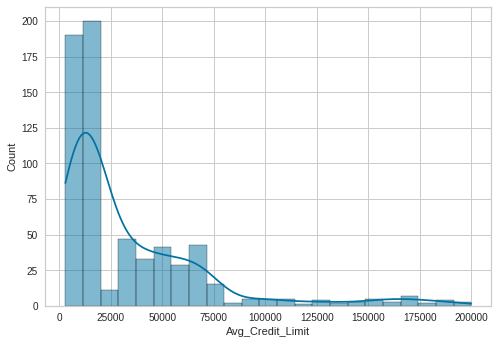

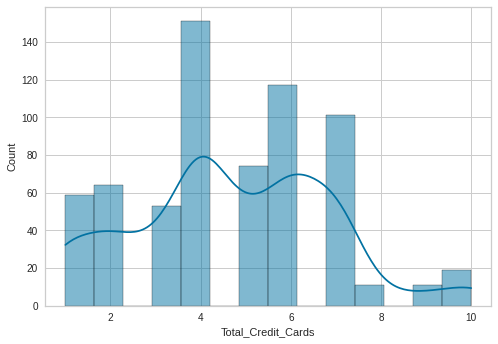

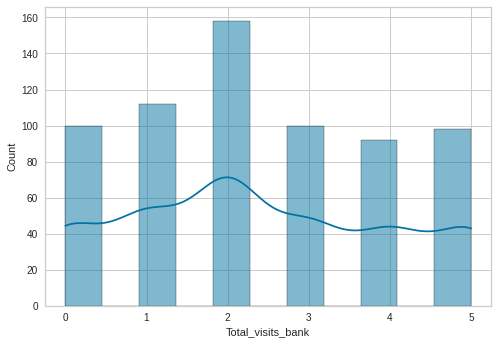

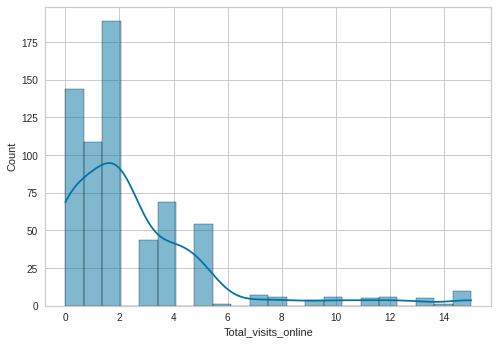

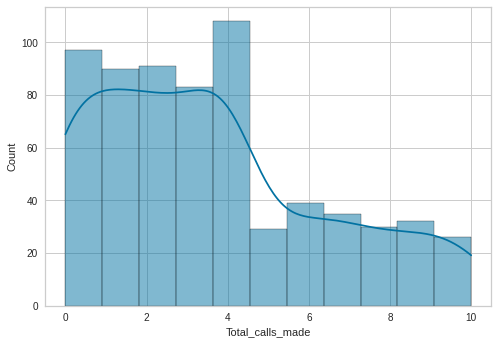

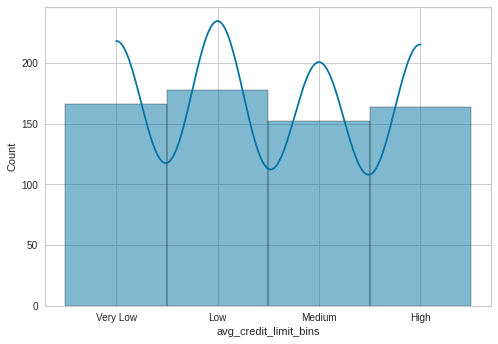

In [31]:
for col in data.columns:
  sns.histplot(data=data, x=col, kde=True);
  plt.show()

In [32]:
#Dropping the column that was created to partition the credit limits into 4 different categories/bins (strictly for visualization purposes)
data.drop('avg_credit_limit_bins', axis=1, inplace=True)

**Observations**

Avg Credit limit is heavily right skewed with more customers having lesser avg credit limits - less than 25K.

Customers who have 4 credit cards are more than the rest.

Customers who visited the bank twice are more than the rest.

Customers who used the online services twice are more in number.

Majority of the customers made four or less calls to the bank.




















# Outlier detection using Boxplot

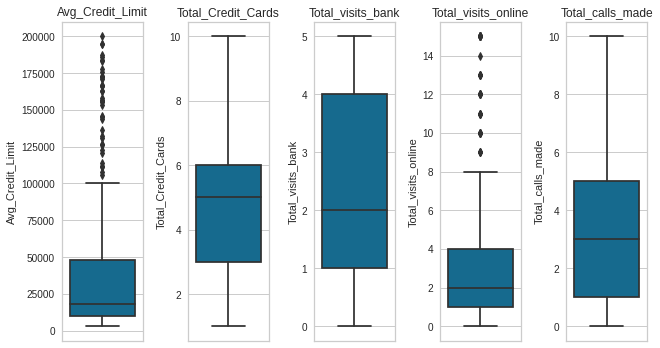

In [33]:
#Let us plot boxplots for all the columns
plt.figure(figsize=(25,5))

for i, variable in enumerate(data.columns):
    plt.subplot(1,14,i+1)
    sns.boxplot(y=data[variable], orient='h')
    plt.tight_layout()
    plt.title(variable)

plt.show()

**Observations on Outliers derived from Box Plots**

Avg_Credit_Limit as expected from the statistical summary and histograms has outliers on the higher end. 

Total_visits_online as expected from the statistical summary and histograms has outliers on the higher end. 

Unlike the tree based algorithms, the clustering algorithms are impacted by the outliers. Let us take a closer look at the outliers to see if they are valid and acceptable given the domain.


# Labeled Bar-plots

In [34]:
# function to create barplots with percentages labled on the bars


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 3))
    else:
        plt.figure(figsize=(n + 1, 3))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [35]:
candidates_for_barplots = ['Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made']

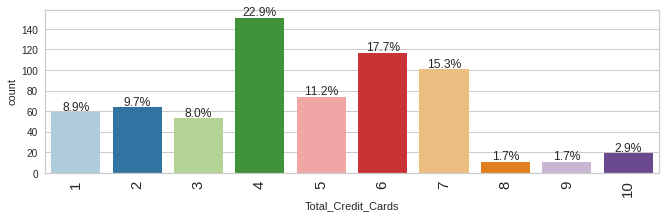

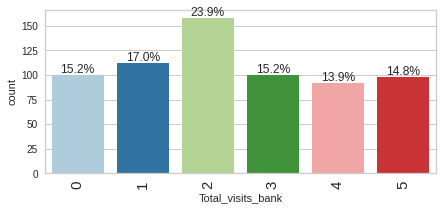

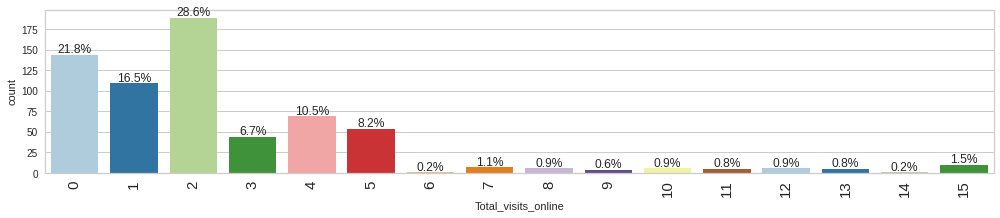

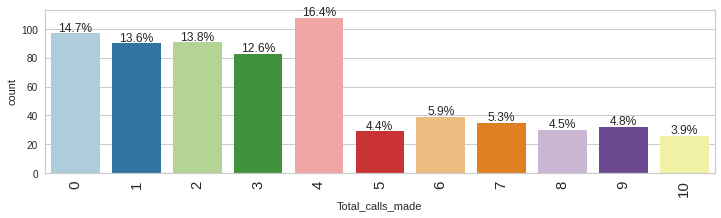

In [36]:
for col in candidates_for_barplots:
 labeled_barplot(data, col, perc=True) 

**Observations**

The customer base seem to be almost equally distributed among the 4 credit limit bins.

23% of the customers have 4 credit cards, followed 6 and 7 credit cards. Very few have of them have 8 or more cards.

~160 customers visited the bank twice.

~29% of the customers used the online services twice and a great majority of the customers utlitized the online services  5 or less times. 

~17% of the customers made 4 calls to the bank with ~53% of them making less than 4 calls. 





# Bivariate Analysis
Goal of Bi-variate analysis is to find inter-dependencies between features.

<Axes: xlabel='Total_Credit_Cards', ylabel='Total_visits_online'>

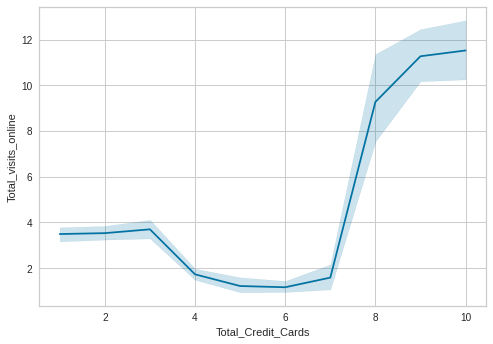

In [37]:
sns.lineplot(x = "Total_Credit_Cards", y = "Total_visits_online", data=data)

<Axes: xlabel='Total_Credit_Cards', ylabel='Total_calls_made'>

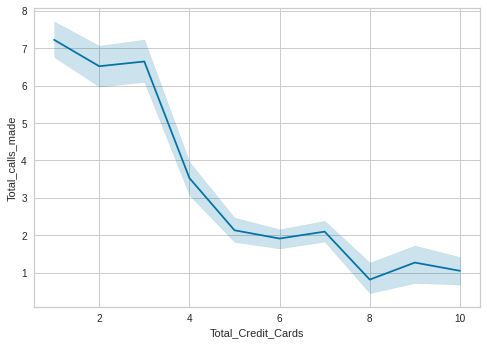

In [38]:
sns.lineplot(x = "Total_Credit_Cards", y = "Total_calls_made", data=data)

<Axes: xlabel='Total_Credit_Cards', ylabel='Total_visits_bank'>

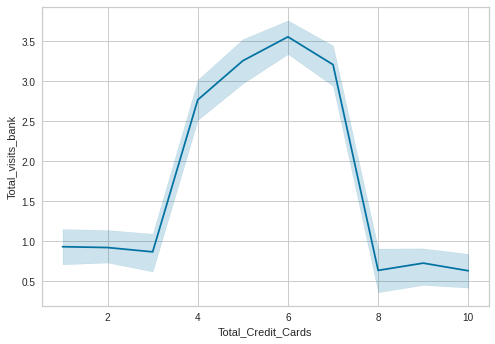

In [39]:
sns.lineplot(x = "Total_Credit_Cards", y = "Total_visits_bank", data=data)

An interesting observation is calls made to the bank reduce as the number of credit cards increase.

Customers who own 1 to 3 credit seem to be calling the bank more the rest.

Customers with 8 to 10 credit cards are utilizing the online services the most.

Customers with 4 to 7 credit cards seem to be visiting the bank the most.

# Multi-variate Analysis
Pair Plot of all the columns

<Figure size 2160x1080 with 0 Axes>

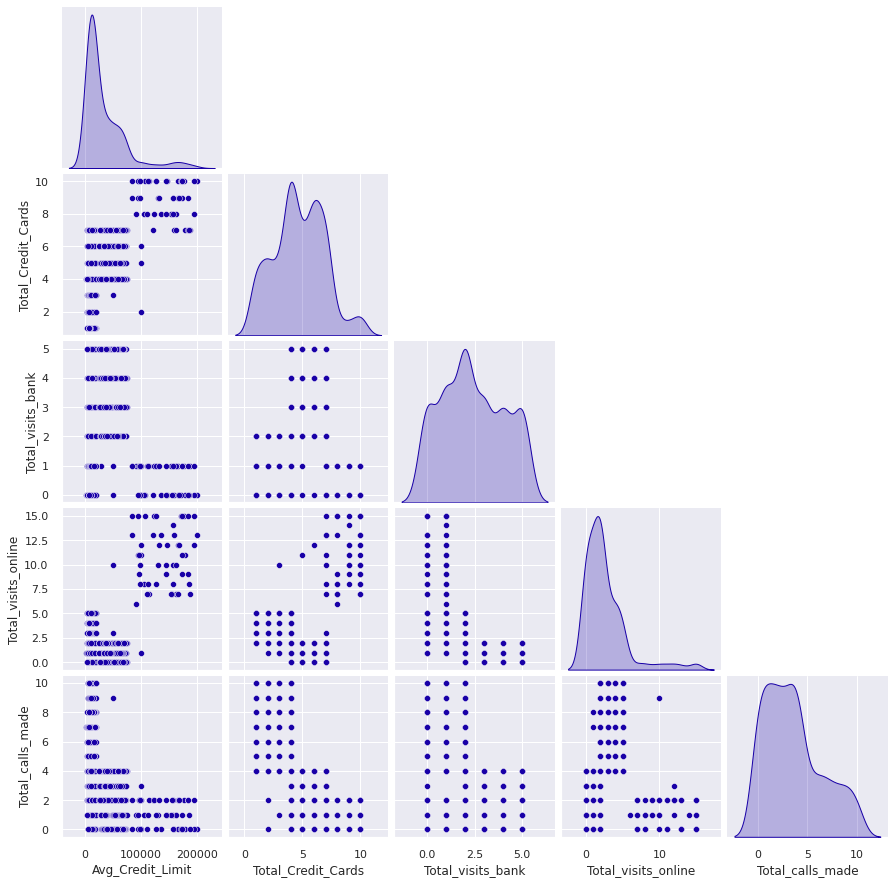

In [40]:
## Below plot shows correlations between the numerical features in the dataset

plt.figure(figsize=(30,15));
sns.set(palette="nipy_spectral");
sns.pairplot(data=data, corner=True, diag_kind='kde');
plt.show()

**Observations**

There seem to be 2 clusters between credit limit and online visits

2 clusters between total online visits and # of credit cards.

# Heatmap to plot the correlations between the columns.

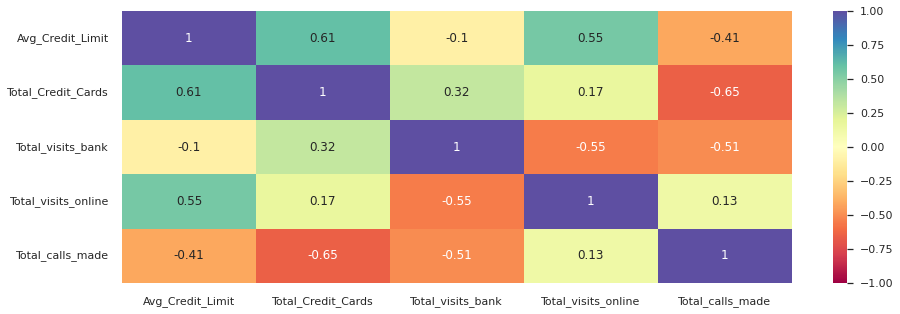

In [41]:
plt.figure(figsize=(15,5))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, cmap='Spectral');

**Observations**

Total_Credit_Cards and Total_visits_online seem to have a moderately positive correlation with Avg_Credit_Limit.

As expected both Total_visits_online and Total_calls_made have a moderately negative correlation with Total_visits_bank.

Total_calls_made seem to have a moderate to high negative relationship with Total_Credit_Cards.

Avg_Credit_Limit seems to have a low to medium negative correlation with Total_calls_made. 

**Bottom Line**

None of the features have a correlation greater than 0.7 (magnitude). Since correlation does not have a negative impact on clustering and since we only have 5 features and 660 observations, we don't have to worry about computational efficiency. So no compelling reason to drop any of the features. 




# Data Preprocessing

# Outlier Treatment

**Using boxplots, we noticed that 2 columns (Avg_Credit_Limit and Total_visits_online) had outliers.**


**Function to determine the lower and upper limits based on the Quantile and IQR**

In [42]:
#Determine the lower_limit and upper_limit (Formulas: Q1-1.5*IQR and Q3+1.5*IQR respectively)
def calculate_limits(data,colmn):
  # Q1 = 25th quantile
    Q1=data[colmn].quantile(0.25)
    
    # Q3 = 75th quantile
    Q3=data[colmn].quantile(0.75)
    
    # Calculating IQR
    IQR=Q3-Q1
    
    # Setting lower limit to Q1-1.5*IQR
    lower_limit = Q1 - 1.5*IQR
    if lower_limit < 0:
        lower_limit = 0

    # Setting upper limit to Q3+1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    
    return lower_limit, upper_limit

In [43]:
# Let us calculate the lower and upper limits of Avg_Credit_Limit using quantiles.
lower_limit, upper_limit = calculate_limits(data,'Avg_Credit_Limit')
print ('Lower cap for Avg_Credit_Limit',lower_limit)
print ('Upper cap for Avg_Credit_Limit', upper_limit)

Lower cap for Avg_Credit_Limit 0
Upper cap for Avg_Credit_Limit 105000.0


In [44]:
#Let us get the number of rows where Avg_Credit_Limit>105000 & let us see what values those rows hold.
temp = data[data['Avg_Credit_Limit']>105000]
print('Rows with more than 105000 Avg_Credit_Limit: {} %'.format(round(temp.shape[0]/data.shape[0]*100)))

Rows with more than 105000 Avg_Credit_Limit: 6 %


In [45]:
#Let us inspect the avg credit limits in these 6%
temp['Avg_Credit_Limit'].value_counts()

163000    2
172000    2
195000    2
166000    2
156000    2
157000    1
171000    1
184000    1
123000    1
144000    1
127000    1
186000    1
173000    1
183000    1
111000    1
112000    1
132000    1
145000    1
153000    1
114000    1
126000    1
106000    1
187000    1
200000    1
155000    1
146000    1
178000    1
176000    1
108000    1
158000    1
121000    1
136000    1
131000    1
167000    1
Name: Avg_Credit_Limit, dtype: int64

Considering the domain, the data is continuos and legitimate and only 6% of the observations have an avg credit limit value higher than the upper limit. 

**Bottom Line - Outlier Treatment on Avg_Credit_Limit**

Given the domain, these outliers are expected and do not warranty any treatment.

In [46]:
# Let us calculate the lower and upper limits of Total_visits_online using quantiles.
lower_limit, upper_limit = calculate_limits(data,'Total_visits_online')
print ('Lower cap for Total_visits_online',lower_limit)
print ('Upper cap for Total_visits_online', upper_limit)

Lower cap for Total_visits_online 0
Upper cap for Total_visits_online 8.5


In [47]:
#Let us get the number of rows where Total_visits_online>8.5 & let us see what values those rows hold.
temp = data[data['Total_visits_online']>8.5]
print('Rows with more than 8.5 Total_visits_online: {} %'.format(round(temp.shape[0]/data.shape[0]*100)))

Rows with more than 8.5 Total_visits_online: 6 %


In [48]:
#Let us inspect the Total_visits_online in these 6%
temp['Total_visits_online'].value_counts(1)

15    0.270270
10    0.162162
12    0.162162
11    0.135135
13    0.135135
9     0.108108
14    0.027027
Name: Total_visits_online, dtype: float64

Considering the domain, the data is continuos and legitimate and only 6% of the customers have utilized the online services more than the upper limit of 8.5. 

**Bottom Line - Outlier Treatment on Total_visits_online**

Given the domain, these outliers are expected and do not warranty any treatment.

# Data Preparation for Unsupervised Learning

# What is feature scaling?

Feature scaling is a class of statistical techniques that, as the name implies, scales the features of our data so that they all have a similar range. You'll understand better if we look at an example:

If you have multiple independent variables like age, salary, and height, With their range as (18–100 Years), (25,000–75,000 Euros), and (1–2 Meters) respectively, feature scaling would help them all to be in the same range.

**Why feature scaling is improtant in Unsupervised Learning?**

Feature scaling is specially relevant in machine learning models that compute some sort of distance metric, like most clustering methods like K-Means.

So, scaling should be done to avoid the problem of one feature dominating over others (Avg_Credit_Limit in this particular case) because the unsupervised learning algorithm uses distance to find the similarity between data points.

In [49]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = data.copy()
subset_scaled = scaler.fit_transform(subset)

In [50]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

# K-means Clustering

In [51]:
clusters = range(2, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)


Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9426543606899347
Number of Clusters: 7 	Average Distortion: 0.9093991915419353
Number of Clusters: 8 	Average Distortion: 0.8843243844476886


# Generate the Elbow Curve to determine the most appropriate value for K (# of clusters)

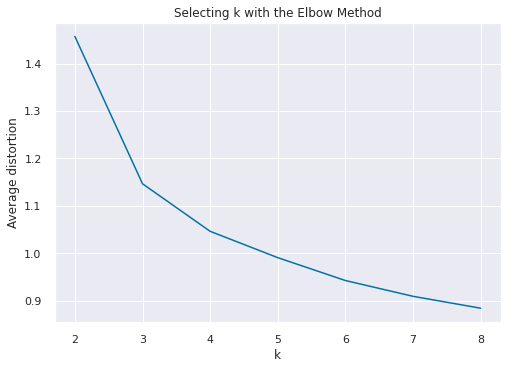

In [52]:
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

**3 seems to be the ideal value for k. Let us also take a closer look at 4.**

# Let's check the silhouette scores.

**What is silhouette score?**

Silhouette score is one of the methods for evaluating the quality of clusters created using clustering algorithms such as K-Means. The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Silhouette score has a range of [-1, 1].

Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters.

Silhouette score near -1 indicates that those samples might have been assigned to the wrong cluster.

In [53]:
sil_score_kmeans = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score_kmeans.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))



For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.2717470361089752)
For n_clusters = 6, the silhouette score is 0.255906765297388)
For n_clusters = 7, the silhouette score is 0.24798644656011146)
For n_clusters = 8, the silhouette score is 0.2414240144760896)
For n_clusters = 9, the silhouette score is 0.2184645050755029)


**Generate the Silhouette Plot**

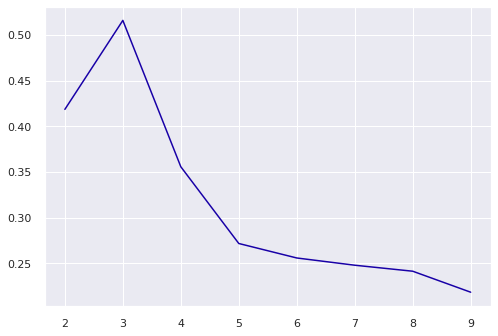

In [54]:
plt.plot(cluster_list, sil_score_kmeans)
plt.show()

**The Silhouette score clearly hits a max of 0.51 at k=3. So, we will choose 3 as value of k.**

**Let's do deeper investigation for different K values using SilhouetteVisualizer**

# How to interpret the results of SilhouetteVisualizer?
Below are the points that every cluster needs to satisfy for selecting the optimal K-value.

There should be no negative silhouette coefficent value

All the clusters should cross the avg silhouette score

All the clusters should have the different variations (width)

All the clusters should have different silhouette score


**Note**

Width of each cluster refers to the size of each cluster. (Number of data points present in each cluster)

Horizontal line refers to the Silhouette score of each cluster.

Dotted red line is an Average Silhouette score.

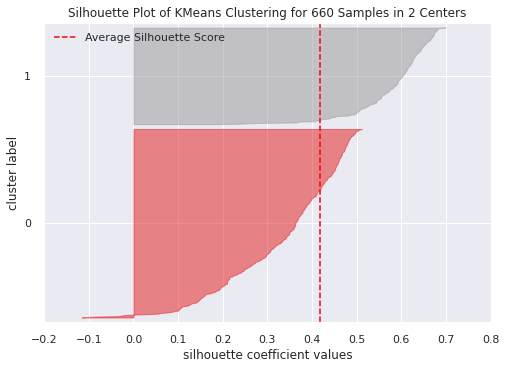

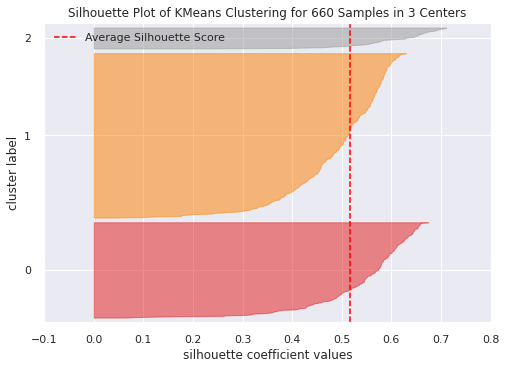

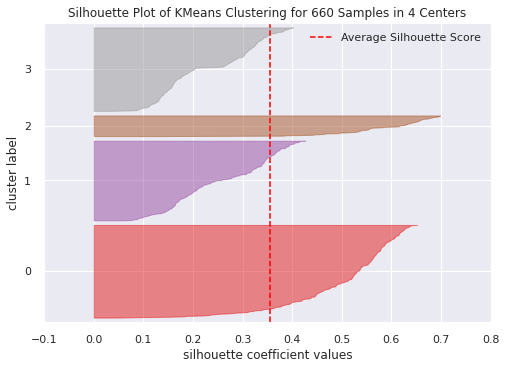

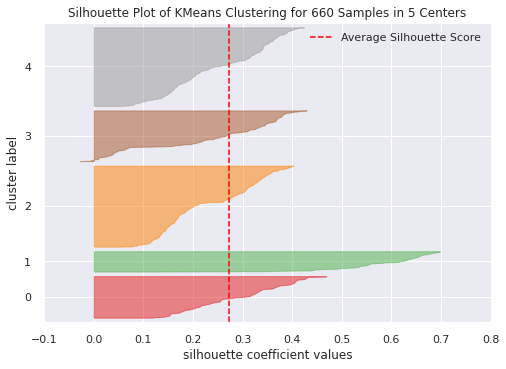

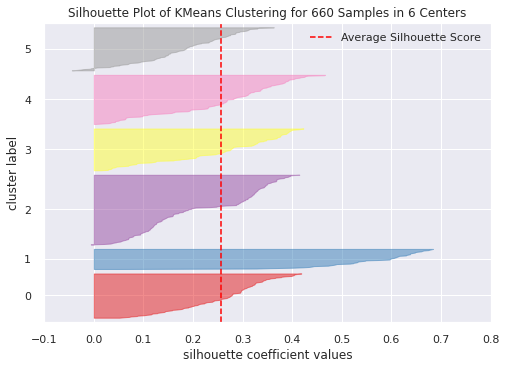

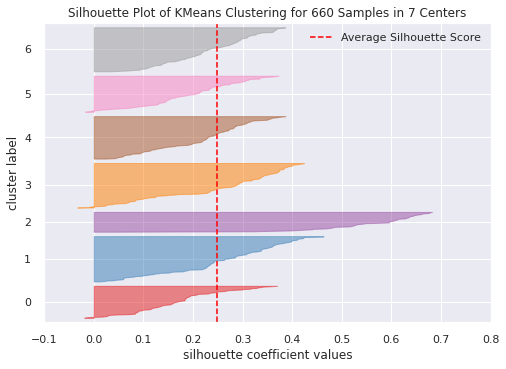

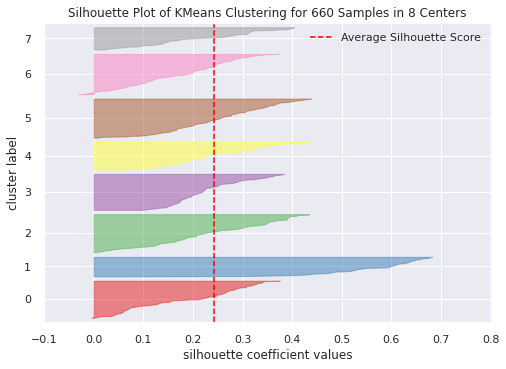

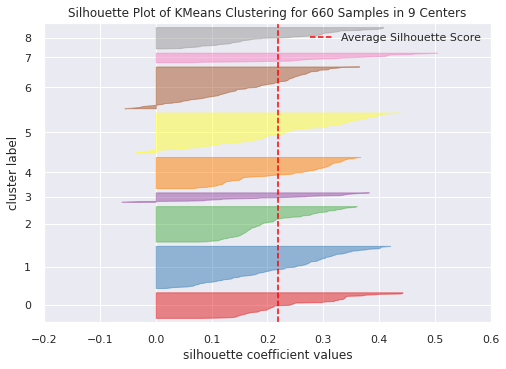

In [55]:
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
  visualizer = SilhouetteVisualizer(KMeans(n_clusters, random_state=1))
  visualizer.fit(subset_scaled_df)
  visualizer.show()

**Observations**

**k=2:** Cluster 0 has negative coefficient values and the average silhouette coefficient value is ~0.45.

**k=3:** **All the 3 clusters have above average silhouette coefficient values and none of them have negative coefficient values. The average silhouette coefficient value is ~0.55, the best across all possible values of k. The 3 clusters have different widths and each of them have different silhouette scores.**

**k=4:** Cluster 3 barely crosses the average silhouette coefficient value of  0.35 which is quite low. 

**k=5:** The average silhouette coefficient value is very low at ~0.28 and 1 cluster has negative coefficient values.

**k=6:** The average silhouette coefficient value is very low at ~0.25 and 2 clusters have negative coefficient values.

**k=7:** The average silhouette coefficient value is very low at ~0.22 and 3 clusters have negative coefficient values.

**k=8:** The average silhouette coefficient value is very low at ~0.22 and 2 clusters have negative coefficient values.

**k=9:** The average silhouette coefficient value is very low at ~0.23 and 3 clusters have negative coefficient values.


In [56]:
# Let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=1)

# Cluster Profiling - KMeans - n_clusters=3

In [57]:
# Adding kmeans cluster labels to the original and scaled dataframes

data["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_

In [58]:
cluster_profile = data.groupby("K_means_segments").mean()

In [59]:
cluster_profile["count_in_each_segments"] = (
    data.groupby("K_means_segments")["Total_calls_made"].count().values
)

In [60]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [61]:
data['K_means_segments'].value_counts(normalize=True)*100

1    58.484848
0    33.939394
2     7.575758
Name: K_means_segments, dtype: float64

**Visualise the Clusters**

Boxplots for K Means Clusters

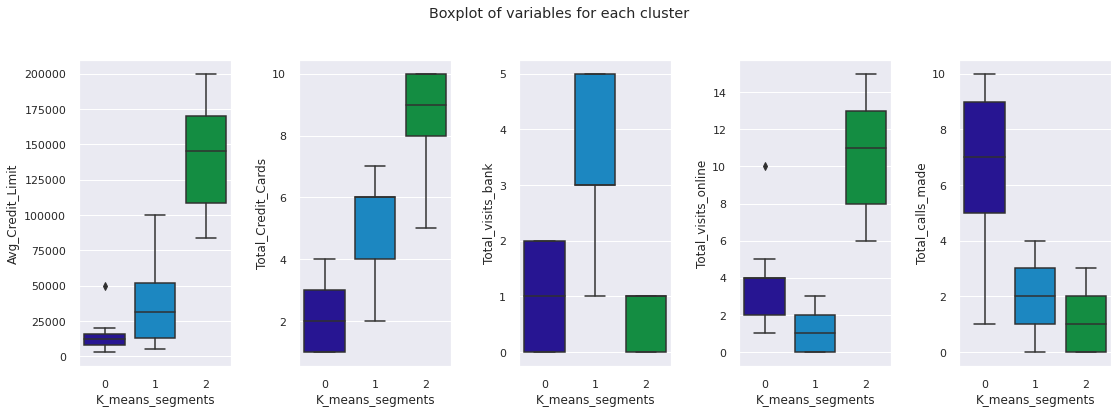

In [62]:
num_col = data.columns
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=data[num_col[counter]], x=data["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

**Cluster Analysis - KMeans - n_clusters=3**

**Cluster 0:** This cluster has customers with low credit limit, fewer credit cards, medium bank visits, medium online visits and highest calls to bank. This cluster has 224 customers which makes up 34% of the total customer base. Makes this the 2nd largest cluster.


**Cluster 1:** Customers with medium credit limit ,medium number of credit cards (~5,6), Highest average bank visits and very less online visits and medium calls to bank belong to this Cluster. Has 386 customers accounting to 58.5% of the customer base. This cluster is the largest of the three.

**Cluster 2:** This cluster includes cutomers with highest Avg credit limit, highest number of credit cards, very less bank visits, highest online visits and fewer calls made to bank. Has 50 customers accounting to 7.5% of the customer base.

# Hierarchical Clustering

**Calculating Cophenetic correlation for all the Linkage Methods - Euclidean Affinity**

In [63]:
# list of distance metrics
distance_metrics = ["euclidean"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.8981791108157512.
Cophenetic correlation for Euclidean distance and complete linkage is 0.884420725860894.
Cophenetic correlation for Euclidean distance and average linkage is 0.9102691112621796.
Cophenetic correlation for Euclidean distance and centroid linkage is 0.906845257340526.
Cophenetic correlation for Euclidean distance and ward linkage is 0.7566252666432097.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.9069999252384202.


In [64]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9102691112621796, which is obtained with Euclidean distance and average linkage.


Cophenetic correlation of 0.91 is the max value observed for the Euclidean affinity for average, centroid and weightage linkages.

**Since we have outliers in the data, let us also draw the dendrograms using the manhattan aka cityblock affinity to see if the score increases.**

**Calculating cophenetic correlation for Linkage Methods supported by Cityblock/Manhattan Affinity**

**Note** - Centroid and Ward linkage options require Eucledian Affinity and hence not listed for the manhattan/cityblock affinity used below.

In [65]:
# list of distance metrics
distance_metrics = ["cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Cityblock distance and single linkage is 0.8519946783967026.
Cophenetic correlation for Cityblock distance and complete linkage is 0.8928953430241594.
Cophenetic correlation for Cityblock distance and average linkage is 0.908076618085445.
Cophenetic correlation for Cityblock distance and weighted linkage is 0.8862785891794108.


In [66]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.908076618085445, which is obtained with Cityblock distance and average linkage.


Cophenetic correlation of 0.91 is the max value observed for the Manhattan/CityBlock affinity for average linkage.

# Plotting Dendrograms for each linkage method - Euclidean Affinity

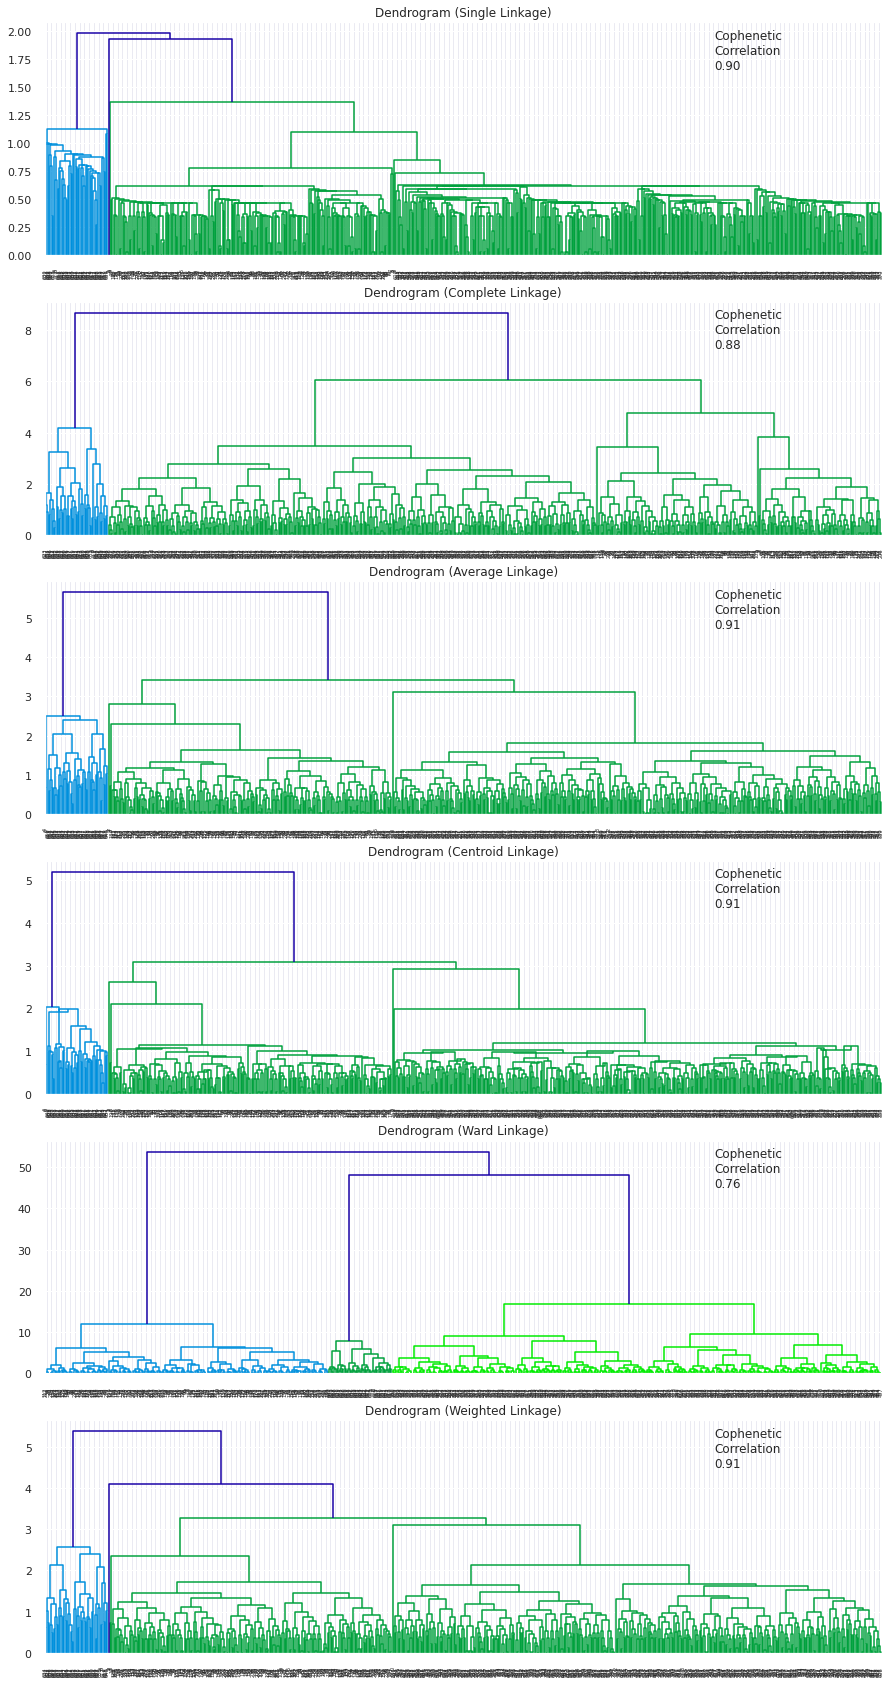

In [67]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

**Observation - Dendrograms- Eucledian Affinity**

Except for the dendrogram representing Single linkage, the rest of the  dendrograms shows 3 clusters with clear data segregation.

Dendrogram with Ward Linkage shows very clear segregation of the clusters though it only has a cophenetic correlation of 0.76.

# Plotting Dendrograms for each linkage method supported by Cityblock/Manhattan Affinity

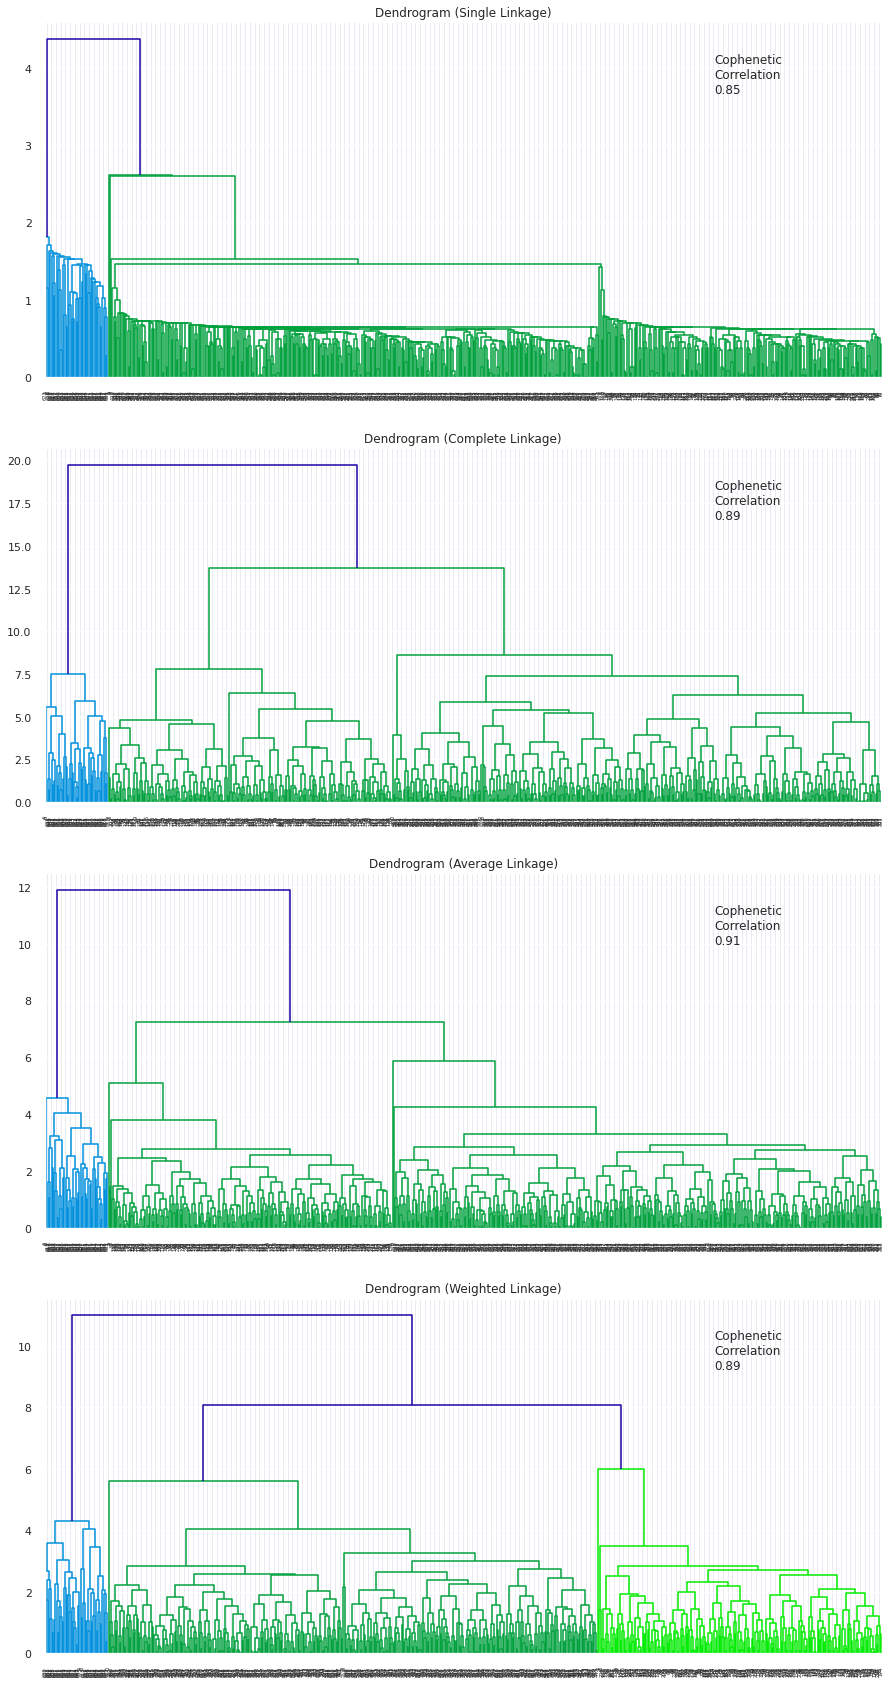

In [68]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="cityblock", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

**Observation - CityBlock/Manhattan Affinity**

Except for the dendrogram representing Single linkage, the rest of the  dendrograms show 3 clusters with clear data segregation.

**Dendrograms - Comparisons**

Out of all the dendrograms we saw, it is clear that the dendrogram with Ward linkage, using eucledian distance metric gave us separate and very distinct clusters. However the cophenetic correlation value however is at 0.76 which is good though not the best. The next dendrogram with distinct clusters seem to be the one drawn using Complete Linkage & Cityblock/Manhattan distance metric - this dendrogram yeilds a cophenetic correlation of 0.89. Let us go with this combination.

Drawing a horizontal line at 13 in Complete Linkage & Cityblock/Manhattan distance metric dendrogram, 3 would be the appropriate number of the clusters. Let us also check the silhouette score for 3 clusters.

**Calculate Silhouette scores - Hierarchial Clustering**

In [69]:
# check the silhouette scores
sil_score_hierarchial = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters,affinity="cityblock", linkage="complete")
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score_hierarchial.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.5726503457083241
For n_clusters = 3, silhouette score is 0.5397786437631975
For n_clusters = 4, silhouette score is 0.30314554609249267
For n_clusters = 5, silhouette score is 0.18540321330428153
For n_clusters = 6, silhouette score is 0.16168019054544555
For n_clusters = 7, silhouette score is 0.14234548423225543
For n_clusters = 8, silhouette score is 0.1425607011037043
For n_clusters = 9, silhouette score is 0.1373886865724779


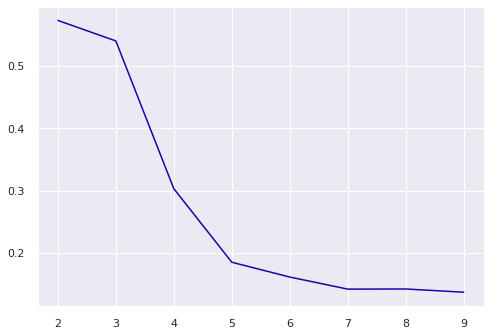

In [70]:
# plot the graph
plt.plot(cluster_list, sil_score_hierarchial)

**Observations:**

Silhouette score also goes to indicate that 3 clusters is the best option.  



**Create 3 Clusters using AgglomerativeClustering with citiblock affinity and complete linkage**

In [71]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="cityblock", linkage="complete")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(affinity='cityblock', linkage='complete', n_clusters=3)

In [72]:
# adding hierarchical cluster labels to the original and scaled dataframes

subset_scaled_df["HC_Clusters"] = HCmodel.labels_
data["HC_Clusters"] = HCmodel.labels_

# Cluster Profiling - Hierarchial - n_clusters=3

In [73]:
cluster_profile_hierarchial = data.groupby("HC_Clusters").mean()

In [74]:
cluster_profile_hierarchial["count_in_each_segments"] = (
    data.groupby("HC_Clusters")["Total_visits_online"].count().values
)

In [75]:
# let's display cluster profiles
cluster_profile_hierarchial.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,1.000000,386
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12174.107143,2.410714,0.933036,3.553571,6.870536,0.000000,224


**Visualise the Clusters**

Boxplot for HC_Clusters

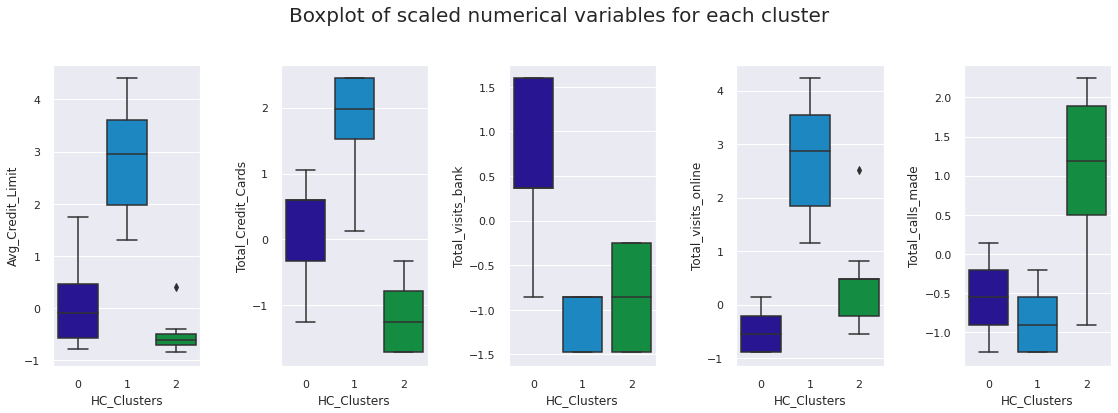

In [76]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

**Cluster Analysis - Hierarchial - n_clusters=3**

**Cluster 0:** Customers with medium credit limit ,medium number of credit cards (~5,6), highest average bank visits and very less online visits and medium calls to bank belong to this Cluster. This cluster has 386 customers accounting to 58.5% of the customer base. This cluster is the largest of the three.


**Cluster 1:** This cluster includes cutomers with highest Avg credit limit, highest number of credit cards, very less bank visits, highest online visits and fewer calls made to bank. Has 50 customers accounting to 7.5% of the customer base.



**Cluster 2:** This cluster has customers with low credit limit, fewer credit cards, medium bank visits, medium online visits and highest calls to bank. This cluster has 224 customers which makes up 34% of the total customer base. Makes this the 2nd largest cluster.

**Silhouette score comparison between KMeans and Hierarchial Clusters**

In [77]:
# create dataframe
comparison_frame = pd.DataFrame({"Clusters":["2","3","4","5","6",
                                          "7","8","9"], 
                                          "KMeans Score": sil_score_kmeans, "Hierarchial Scores": sil_score_hierarchial
                                         }) 
comparison_frame

,Clusters,KMeans Score,Hierarchial Scores
0,2,0.418425,0.572650
1,3,0.515718,0.539779
2,4,0.355667,0.303146
3,5,0.271747,0.185403
4,6,0.255907,0.161680
5,7,0.247986,0.142345
6,8,0.241424,0.142561
7,9,0.218465,0.137389


**K-means vs Hierarchical Clustering**

Both clustering mechanisms recommend 3 clusters as ideal for classification based on the method of communication with the bank. 

The 3 clusters from each model (KMeans, Hierarchial) have similar distributions of customers under each cluster - 50, 224, 386(exception being Single linkage). 

Both KMeans and Agglomerative clustering yielded the highest silhouette scores for k=3. 

Since our dataset is small with just 660 observations and 5 features, we can go with either K Means or Hierarchical clustering. 

**Hierarchical clustering can’t handle big data well but K Means clustering can. This is because the time complexity of K Means is linear i.e. O(n) while that of hierarchical clustering is quadratic i.e. O(n2).

In K Means clustering, since we start with random choice of clusters, the results produced by running the algorithm multiple times might differ, while results are reproducible in Hierarchical clustering. K Means is found to work well when the shape of the clusters is hyper spherical (like circle in 2D, sphere in 3D). 

The result of K-means is unstructured, but that of hierarchal is more interpretable and informative.



# Conclusion

Based on the credit limit and the mode of communication with the bank, 3 distinct categories of customers were identified. These customer segments mainly differ based on credit limits as below.

1 --> High Credit Limit & prefering online banking

Customers who have high credit limit seem to be high spenders with more number of credit cards and they prefer to bank online rather than visiting the bank or calling the bank.

2 --> Medium Credit Limit & prefering bank visits

Customers with medium credit limit have more credit cards (when compared to low credit customers) and have less calls made to bank as compared to low credit customers but have more visits to bank overall. These are the most active user group.

3 --> Low Credit Limit & prefering calling the bank

Customers who have low credit limit have less number of credit cards and have more calls made to the bank.


# Actionable Insights

**Data Collection Enhancements**

It would be beneficial to gather the customer support satisfaction rating, so we will able to identify the support channel (onsite, online or over the phone) with the least rating and prioritize that channel for immediate enhancements.We got ~54% of the customers using all the 3 communication channels. The customers who seem to use the online services often are also visiting the bank and calling the bank. Since using the online service is the most convenient channel, we will have to assume not all functionality is supported online that is forcing the users to call and/or visit the bank. 

We also will benefit from gathering information in regards to the customer's prefered mode of communication. Just because a customer visits the bank, we do not want to assume that visiting the bank is the customer's preferred mode of communication - it could very well be that the customer believes (from their dealings in the past) that issues only get resolved when they talk to someone face to face. It is possible that the customer prefers visiting the bank online, but the site might be too slow to respond and not efficient enough thus forcing the customers to visit the bank instead.

In order to encourage customers to use the online services, we must first know the reason behind them not using online services. We do not have enough information in regards to the Age or Education. 



# Recommendations

Based on how bank wants to promote its products and services, a segment of customers can be targeted as we know their prefered mode of commmunication.

Customers with high credit limit tend to vist online. Hence they can be targeted for online campaigns, coupons and accordingly products and services can be offered to them. These customers only make 7.5% of the customer base and lot of room to widen this segment.

Customers with comparatively low credit limit make visits to bank more often, hence they can either be prompted with benefits of online banking or can be catered with in-bank offers/services and flyers. These customers make the majority of the customer base.

Customers with low credit limits have less frequency on online platform, they can be marketed with benefits of online banking and/or make customer call center reps aware of promotions and offers so that they can effectively target this segment of customers.

Bank also needs to have monitoring setup to detect a change in the customer communication mode so the method of contact can be changed accordingly. 


